# DonorSearch
## Предобработка медицинских документов

DonorSearch -  занимается развитием донорства в стране. Для этого есть платформа DonorSearch.org. Существующая версия сервиса требует вертикальной ориентации справки. Необходимо разработать модель определения ориентации справки и автоматического поворота ее в нормальное положение перед запуском сервиса OCR.


**План:**

1. Загрузить датасет
    * Провести предобработку и аугментацию    
2. Разбить на выборки
3. Разработать модель на основе torch
    * Преобразовать выборки
    * Обучить модель
    * Протестировать модель
    * Сохранить модель для дальнейшего использования 
5. Разработать микросервис
    * Вебсервис на основе FastApi
    * Docker для развёртки


**Примечания:**

* Импортирование модулей для модели отдельно, в разделе torch.
* Микросервис выполнен в отдельно, в папке `app`, файл.
* Для удобства организации также в отдельный файл выделен механизм преобразования изображений, импортируемый в проект как `app.src.transforms_custom`.

## Импорт

In [2]:
import os
import zipfile
from shutil import rmtree
from PIL import Image
from math import ceil

from sklearn.model_selection import train_test_split
from numpy.random import seed as np_seed, choice

## Глобальные

In [3]:
os.chdir(globals()['_dh'][0]) # REDUNDANCY

RANDOM = 241002
np_seed(RANDOM)

PATH_IMG = 'images'
PATH_ZIP = 'images-20240912T162646Z-001.zip'
PATH_TMP = 'images_tmp'
FOLDERS = ['0', '90', '180', '270']


Настройки ниже позволяют несколько изменить с какими изображениями и как будет работать проект. 

*  USE_444_TRAIN - Использовать ли скриншоты андроида в обучении. Позволяет программе чуть лучше распознавать символы.
*  USE_444_VAL_TEST - Использовать ли скриншоты андроида в тесте. 
*  FRACTION - Какую часть фотографий использовать для каждого угла разворота. Может помочь против переобучения если доступен больший объём данных. Не используется.
*  VAL_TEST_SPLIT_PERCENTAGE - Какую часть фотографий оставить для проверки и теста. 0.2 подразумевает 60% 20% 20% разбиение по выборкам

In [4]:

USE_444_TRAIN = True            # Bit better if true
USE_444_VAL_TEST = False        # Relevant only if True above
FRACTION = 1                    # how many % to use for each angle of rotation
VAL_TEST_SPLIT_PERCENTAGE = .2  # used for both val and test, 0.2 => 0.6 / 0.2 / 0.2 split

if not USE_444_TRAIN and USE_444_VAL_TEST:
    raise Exception("Нужно поправить USE_444")
elif not 0 < FRACTION <= 1:
    raise Exception("Нужно поправить FRACTION")
elif not 0 < VAL_TEST_SPLIT_PERCENTAGE <= 0.5:
    raise Exception("Нужно поправить VAL_TEST_SPLIT_PERCENTAGE")
else:
    print('OK') 

OK


## Загрузка датасета

In [5]:
try:
    img_list = os.listdir(PATH_IMG)    
except:
    img_zip = zipfile.ZipFile(PATH_ZIP, 'r')
    img_zip.extractall()
    img_list = os.listdir(PATH_IMG)    

if len(img_list) == 173:
    print('OK')
else:
    try:
        img_zip = zipfile.ZipFile(PATH_ZIP, 'r')
        img_zip.extractall()
        img_list = os.listdir(PATH_IMG)
        if len(img_list) == 173:
            print('OK')
        else:
            print('Изображений меньше чем ожидалось.')
    except: 
        print('Что-то пошло не так.')

OK


In [6]:
# Note
# '405___522b0fcfc8be4e208ef71493901f598c.png' not a 405

len(img_list) 

173

### Фильтрация

In [7]:
odd_444 = [
    '444___7820ca3c69a44d98ae043a6b33dc6201.png',
    '444___326636548b2d460bb9a369853d1bdb7a.png',
    '444___b577d455dc634fce8b6521e0850ce61a.png',
    '444___dc9fdd4d56eb46c3b1af97fab865a913.png',
    '444___e7c001f7a3b24916a944e038e01c32b7.png',    
]

In [8]:
rot_90 = [
    '402___335f83b3a37b403fb31088c8132f74b4.png',
    '405___a0130627fd7b4928b1928834e0c4a628.png',
    '405___b0eda34aa0904f279cade3e518373fd0.png'
]
    

In [9]:
rot_270 = [
    '405___399c076c405d45d7a5687b64c363804f.png',
    '448___0d7a07e66a304764a8de469e179e0aaf.png',
    '448___89bc8cf8b0274ae1b50e6620d302a1ea.png',
    '448___7570f37b00304f1cac7bb08cc045eb15.png'
]
    

In [10]:
img_filtered = [x for x in img_list if not x in rot_90 
                                   and not x in rot_270
                                   and x not in odd_444
                                   ]

if not USE_444_TRAIN:
    img_filtered = [x for x in img_filtered if '444_' not in x]

len(img_filtered)

161

### Разворот вручную

In [11]:
rmtree(PATH_TMP, ignore_errors=True)
os.makedirs(PATH_TMP, exist_ok=True) 

for name in rot_90:
    location = os.path.join(PATH_IMG, name)
    target = os.path.join(PATH_TMP, name)
    Image.open(location).rotate(-90, expand=True).save(target)

for name in rot_270:
    location = os.path.join(PATH_IMG, name)
    target = os.path.join(PATH_TMP, name)
    Image.open(location).rotate(-270, expand=True).save(target)

### Полный список

In [12]:
img_full = [os.path.join(PATH_IMG, name) for name in img_filtered]
img_full += [os.path.join(PATH_TMP, name) for name in rot_90 + rot_270]
img_full

['images\\402___136d64ae8d174354bc2af057d77f93a7.png',
 'images\\402___87e9b407c1e5485e9872ff3acf484731.png',
 'images\\402___96f14679afdb4078bb277152b1b6c215.png',
 'images\\402___fa2f8d33a9cc4318b720f1086df67e3a.png',
 'images\\402___fae1da9d75d54e24bcf24955ecf739a2.png',
 'images\\402___fb3c4f1a217f4a5fbd7f57f564faf876.png',
 'images\\402___fce6c5ae9915468da82fd20ca9b6a356.png',
 'images\\402___ff8c4114eca947b28c0d32ae154620b7.png',
 'images\\405___049481224374486ead31511817c052f3.png',
 'images\\405___087ff98ba556407fb0403a096d726c4e.png',
 'images\\405___2601bf92cd624eb6ac16ed3637c67f57.png',
 'images\\405___4374492a8d5349bd9fbe60caa2dee960.png',
 'images\\405___522b0fcfc8be4e208ef71493901f598c.png',
 'images\\405___655a928741bc4661ae4b509f9b12bc0e.png',
 'images\\405___701b3c25428b4f6c8d71396037202683.png',
 'images\\405___82094d1fddd946c3a7fdeff1f22b06fe.png',
 'images\\405___832661c2c0a5411ab86bf4eb5ad53dc3.png',
 'images\\405___83a46dc4d8554fecae624a5422028422.png',
 'images\\

## Выборки

In [13]:
if not USE_444_TRAIN:
    img_better_target = img_full
elif not USE_444_VAL_TEST:
    img_better_target = [x for x in img_full if '444_' not in x]
    len(img_better_target)
elif USE_444_VAL_TEST:
    img_better_target = img_full
else:
    raise Exception("Нужно поправить глобальные")

In [14]:
split_size = ceil(len(img_better_target) * VAL_TEST_SPLIT_PERCENTAGE)
split_size

20

In [15]:
train, test = train_test_split(img_better_target, test_size=split_size)
train, val = train_test_split(train, test_size=split_size)
train = [x for x in img_full if x not in val 
                            and x not in test
                            ]


In [16]:
def fraction_variant_rotations(list_of_images, fraction):
    not_to_use = int(len(list_of_images)*(1 - fraction))
    if fraction != 1:
        rot0, rem0 = train_test_split(list_of_images, test_size=not_to_use)
        rot1, rem1 = train_test_split(list_of_images, test_size=not_to_use)
        rot2, rem2 = train_test_split(list_of_images, test_size=not_to_use)
        rot3 = list(set(rem0 + rem1 + rem2))
        if not not_to_use * 3/4 < len(rot3) < not_to_use * 5/4:
            extra_len = abs(len(rot1)-len(rot3))
            rot_tmp, rem_tmp = train_test_split(list_of_images, test_size=extra_len)
            rot3 += rem_tmp
    else:
        rot0 = rot1 = rot2 = rot3 = list_of_images
    rot_list = [rot0, rot1, rot2, rot3]    
    print(list(map(len, rot_list)))
    return rot_list


In [17]:
train_list = fraction_variant_rotations(train, FRACTION)
val_list = fraction_variant_rotations(val, FRACTION)
test_list = fraction_variant_rotations(test, FRACTION)

[128, 128, 128, 128]
[20, 20, 20, 20]
[20, 20, 20, 20]


### Сохранение изображений по папкам

In [18]:
img_img = []
for img in img_full:
    img_img.append(Image.open(img))
img_dict = dict(zip(img_full, img_img))


In [19]:
def preprocessing_rotate_save(name, sample):
    rmtree(name, ignore_errors=True)
    os.makedirs(name, exist_ok=True)
    for folder, img_sample in zip(FOLDERS, sample):
        path_sf = os.path.join(name, folder)
        rmtree(path_sf, ignore_errors=True)
        os.makedirs(path_sf, exist_ok=True)
        for img_name in img_sample:
            target = os.path.join(path_sf, os.path.split(img_name)[1])
            img_dict[img_name].rotate(int(folder), expand=True).save(target)           

In [20]:
sample_names = ['train', 'val', 'test']
sample_lists = [train_list, val_list, test_list]


for name, sample in zip(sample_names, sample_lists):
    preprocessing_rotate_save(name, sample)

## Torch

### Импорт

In [21]:
# duplicate of above for independent execution
'''
import os
from PIL import Image

RANDOM = 241001
FOLDERS = ['0', '90', '180', '270']
''';

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import DataFrame
from seaborn import heatmap

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [23]:
import sys

sys.dont_write_bytecode = True
from app.src.transforms_custom import transformer_size, IMG_SIZE #224
sys.dont_write_bytecode = False

### Глобальные

In [24]:
BATCH_SIZE = 64
#IMG_SIZE = 224 # see app.src.transforms_custom

In [25]:
torch.manual_seed(RANDOM)
torch.cuda.manual_seed(RANDOM)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [26]:
CLASSES = {FOLDERS[i] : i for i in range(4)}
CLASSES

{'0': 0, '90': 1, '180': 2, '270': 3}

In [27]:
transformer = transformer_size(IMG_SIZE)
transformer

Compose(
    ToTensor()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Класс Photo

In [29]:
class Photo(torch.utils.data.Dataset):
    def __init__(self, path, label, transform):
        self.path = path
        self.label = label
        self.transforms = transform
        self.imgs = os.listdir(os.path.join(self.path, self.label))

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.label, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        target = CLASSES[self.label]

        return self.transforms(img), torch.tensor(target), self.label

    def __len__(self):
        return len(self.imgs)

In [30]:
def concat_sample(sample, transform):
    sample_list = []
    for _ in range(4):
        sample_list.append(Photo(sample, FOLDERS[_], transformer))
    sample_set = torch.utils.data.ConcatDataset(sample_list)
    return sample_set

In [31]:
train_set = concat_sample('train', transformer)
val_set = concat_sample('val', transformer)
test_set = concat_sample('test', transformer)

In [32]:
train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039860155..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06886807..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843136..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0073566055..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.061395925..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005778561..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.

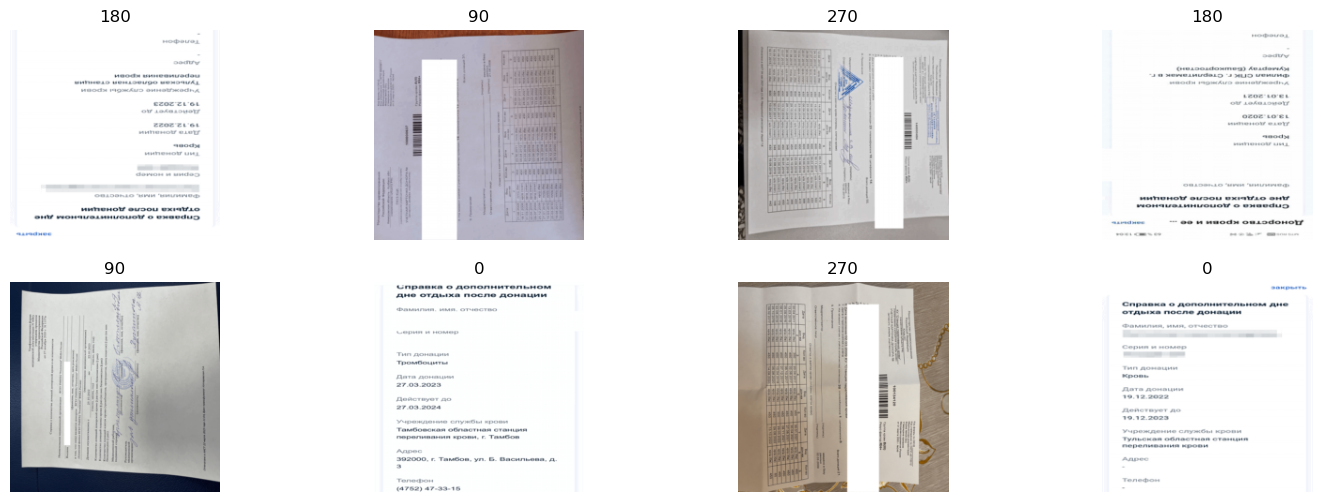

In [33]:
look = next(iter(train_dataloader))
plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[2][i])
plt.show();

## Модель

Train, Eval and Vizualize functions

In [34]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, _ in train_loader: # inputs, labels, _

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [35]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels, _ in val_loader: # inputs, labels, _
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [36]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels, _ in test_loader: # inputs, labels, _
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [37]:
def train_model(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate) # был Adam
        sch = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.01) # был step_size=5 и gamma=0.1

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [38]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    #plt.savefig('loss.png')
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

### Pretrained ResNet50

In [39]:
weights = ResNet50_Weights.DEFAULT #пробовал IMAGENET1K_V1 - 0.76 на 10 эпохах/ IMAGENET1K_V2 - 0.77 на 10 эпохах
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet.fc = torch.nn.Linear(in_features, out_features)
resnet = resnet.to(device)
summary(resnet, (3,IMG_SIZE, IMG_SIZE));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

### Training

In [40]:
ce = torch.nn.CrossEntropyLoss()
lr = 0.005
epochs = 15

In [41]:
# лучшие параметры:
# step_size=5, gamma=0.01, lr=0.001, epochs=10, transforms=CenterCrop - метрика 0.826
# step_size=5, gamma=0.01, lr=0.001, epochs=15. transforms=CenterCrop - метрика 0.9341
# 0.9250 w/o 444
# 0.9250 444 in train but not in val/test split .2
# 0.93 split .25
# .9625 no rotation .2 split 444_train

In [42]:
history = train_model(train_dataloader, val_dataloader, model=resnet, epochs=epochs, rate=lr, criterion=ce)

epoch:   7%|▋         | 1/15 [00:15<03:39, 15.67s/it]


Epoch 001 train_loss: 0.9249     val_loss 420.7758 train_acc 0.5762 val_acc 0.4750


epoch:  13%|█▎        | 2/15 [00:31<03:23, 15.63s/it]


Epoch 002 train_loss: 0.3563     val_loss 43.3017 train_acc 0.8418 val_acc 0.2875


epoch:  20%|██        | 3/15 [00:47<03:10, 15.87s/it]


Epoch 003 train_loss: 0.2470     val_loss 11.2744 train_acc 0.8965 val_acc 0.5625


epoch:  27%|██▋       | 4/15 [01:05<03:04, 16.73s/it]


Epoch 004 train_loss: 0.1710     val_loss 9.7882 train_acc 0.9473 val_acc 0.5250


epoch:  33%|███▎      | 5/15 [01:22<02:47, 16.74s/it]


Epoch 005 train_loss: 0.0703     val_loss 1.5077 train_acc 0.9707 val_acc 0.8000


epoch:  40%|████      | 6/15 [01:36<02:22, 15.80s/it]


Epoch 006 train_loss: 0.0695     val_loss 0.2009 train_acc 0.9785 val_acc 0.9125


epoch:  47%|████▋     | 7/15 [01:49<02:00, 15.03s/it]


Epoch 007 train_loss: 0.0566     val_loss 0.0867 train_acc 0.9805 val_acc 0.9625


epoch:  53%|█████▎    | 8/15 [02:03<01:42, 14.70s/it]


Epoch 008 train_loss: 0.0463     val_loss 0.0881 train_acc 0.9883 val_acc 0.9750


epoch:  60%|██████    | 9/15 [02:17<01:26, 14.43s/it]


Epoch 009 train_loss: 0.0388     val_loss 0.0913 train_acc 0.9863 val_acc 0.9625


epoch:  67%|██████▋   | 10/15 [02:31<01:12, 14.41s/it]


Epoch 010 train_loss: 0.0281     val_loss 0.0959 train_acc 0.9922 val_acc 0.9625


epoch:  73%|███████▎  | 11/15 [02:45<00:56, 14.24s/it]


Epoch 011 train_loss: 0.0267     val_loss 0.0952 train_acc 0.9902 val_acc 0.9625


epoch:  80%|████████  | 12/15 [02:59<00:42, 14.11s/it]


Epoch 012 train_loss: 0.0191     val_loss 0.0962 train_acc 0.9941 val_acc 0.9625


epoch:  87%|████████▋ | 13/15 [03:14<00:28, 14.27s/it]


Epoch 013 train_loss: 0.0269     val_loss 0.0960 train_acc 0.9902 val_acc 0.9625


epoch:  93%|█████████▎| 14/15 [03:28<00:14, 14.23s/it]


Epoch 014 train_loss: 0.0282     val_loss 0.0966 train_acc 0.9883 val_acc 0.9625


epoch: 100%|██████████| 15/15 [03:42<00:00, 14.80s/it]


Epoch 015 train_loss: 0.0229     val_loss 0.0950 train_acc 0.9922 val_acc 0.9625


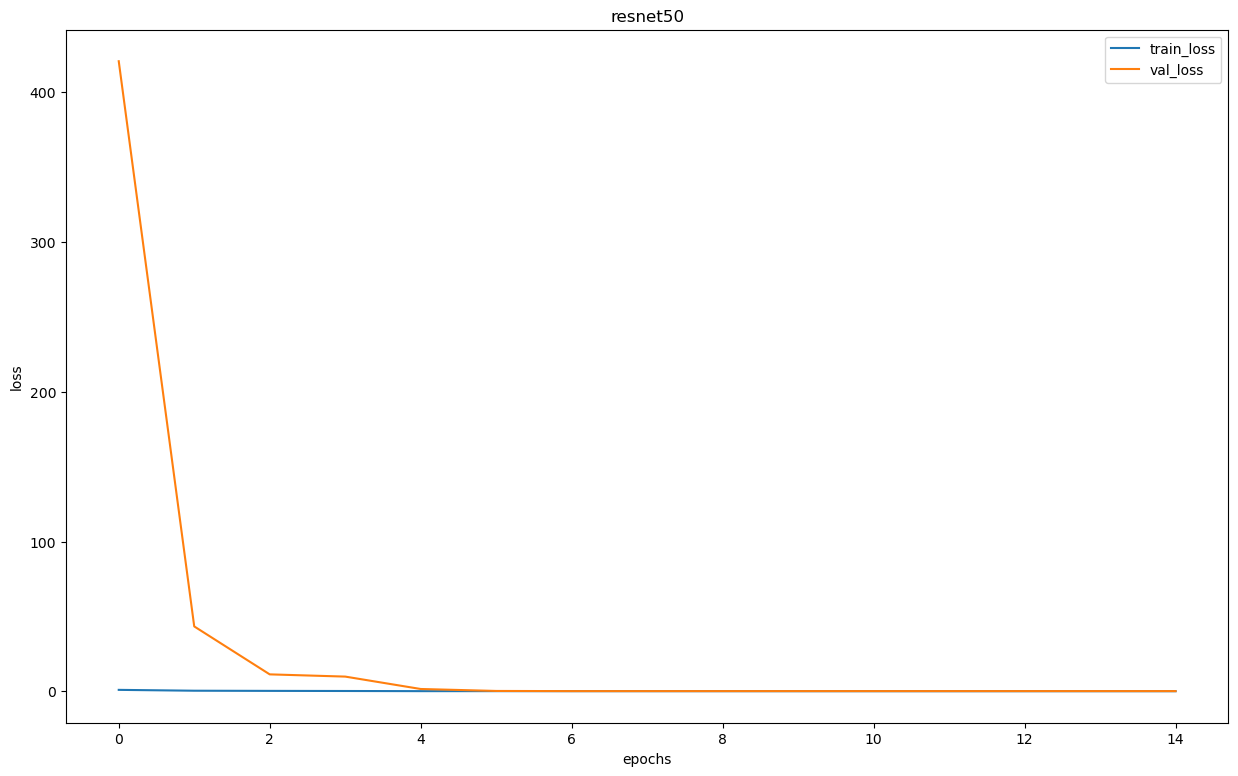

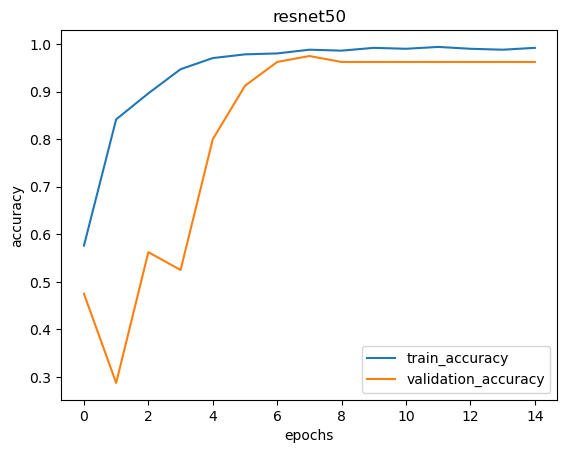

In [43]:
vizualize(history, 'resnet50')

## Тест

In [44]:
result = predict(resnet, test_dataloader)

In [45]:
result[-1]

0.9625

In [46]:
f1_score(result[1], result[0], average='macro')

0.9624295259725297

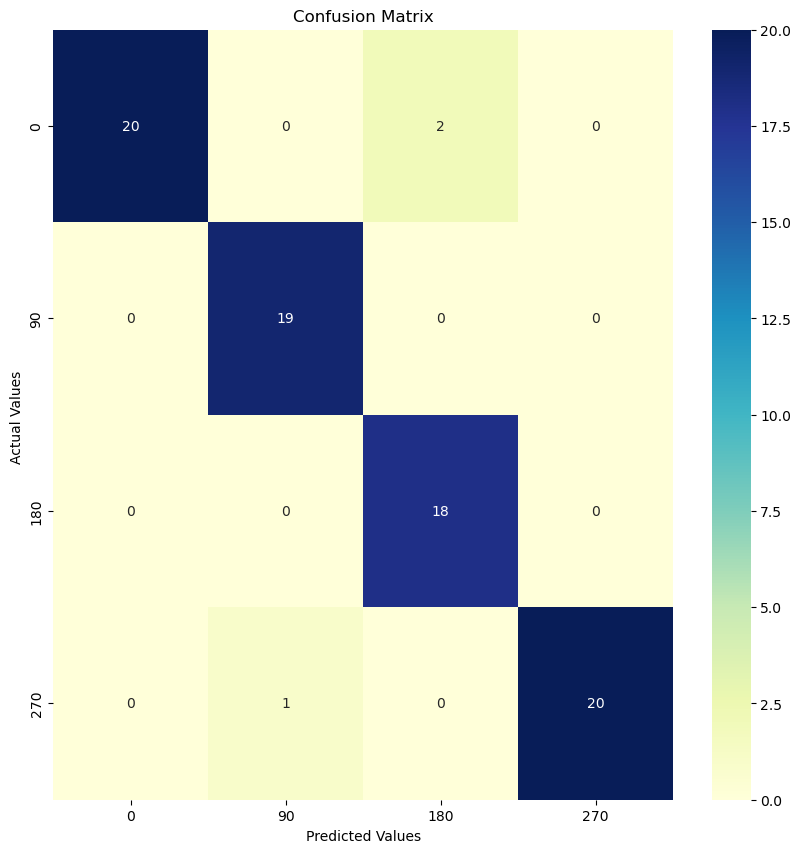

In [47]:
conf_mx = DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','90', '180', '270'])
ax.yaxis.set_ticklabels(['0','90', '180', '270'])
plt.show()

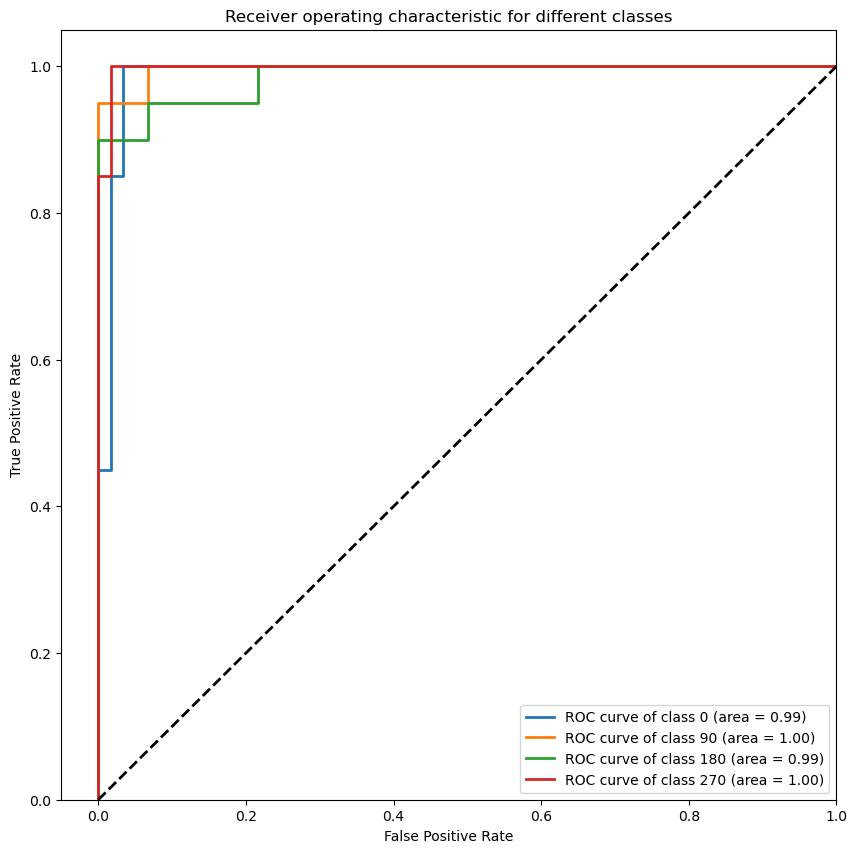

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
#plt.savefig('roc-auc_curve.png')
plt.show()

In [49]:
torch.save(resnet.state_dict(), os.path.join('app', 'src', 'resnet50.pth'))

## Заключение

Получен результат выше 95% на проверке и тесте. Веса модели сохранены в папку с приложением. Главная сложность проекта - маленькое количество данных, даже  с аугментацией результат очень к случайности.

Интересная особенность модели - плохо отличает перевёрнутые документы - при различных конфигурациях ошибки практически всегда на парах (90, 270) и (0, 180).